<a href="https://colab.research.google.com/github/Babcock-R17/Image-Processing/blob/main/Independent_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASKS



1. Fix Layout Structure
  * Inheritance from PIL Image class
2. Create a readme 
  * for the class functions you will be using from the Super Class PIL Image
  * for the functions that will be overrided
  * for the additional functions related to confidence intervals

3. Add Watermark and try to detect the watermark in the image. 
  * Watermark is blended with a transparency mask currently, want to use a custom watermark 
  * Watermark detection 
  * Inpainting, how to remove watermark. 



# pip installs

In [226]:
# Install pillow in order to import PIL 
!pip install pillow
!pip install overloading
!pip install scikit-image

In [227]:
!pip install opencv-python

# Class Reference



Photo Class as Super

```python
class Photo():
  def __init__(self, fp, fname, image):
    self.__fp = fp
    self.__fname = fname
    self.__image = image.astype(np.float32)
    self.__shape = np.asarray(image).shape
    self.__title = fname
```
Image_Processing class as Child. 
```python
class Image_Processing(Photo):
  def __init__(self, fp , fname, img):
    super().__init__(fp, fname, img)
    self.__blur = None
    self.__noise = None
    self.__kernel_size = (0, 0)
    self.__sigma_blur = None
    self.__sigma_noise = None
    self.__mean_noise = None
```

# Run Code for Classes

In [228]:
# Coded by: Jasen Babcock Python 3.7 in Google Colab 03_04_2022
# Imports
# import PIL.Image as Image
from os import listdir
import os
from skimage import io, transform
import PIL
import matplotlib.pyplot as plt
import numpy as np
from typing import overload
import skimage as sk
from multiprocessing import SimpleQueue
from cv2 import cv2


# Class objects
# Parent Class
class Photo():
  def __init__(self, fp, fname, image):
    self.__fp = fp
    self.__fname = fname
    self.__image = image.astype(np.float32)
    self.__shape = np.asarray(image).shape
    self.__title = fname
    

  @property
  def fp(self):
    return self.__fp
  @property
  def fname(self):
    return self.__fname 
  @property
  def image(self):
    return self.__image
  @property
  def shape(self):
    return self.__shape
  @property
  def width(self):
    return self.__shape[0]
  @property
  def height(self):
    return self.__shape[1]
  @property
  def channel(self):
    try:
      return self.__shape[2]
    except ValueError as e:
      print(e)
      return None
  @property
  def title(self):
    return self.__title

  @fp.setter
  def fp(self, fp):
    self.__fp = fp  
  @fname.setter
  def fname(self, fname):
    self.__fname = fname 
  @image.setter
  def image(self, image):
    self.__image = image
  @shape.setter
  def shape(self, shape):
    self.__shape = shape
  @title.setter
  def title(self, title):
    self.__title = title
  


  # Class Methods
  def describe(self):
    name = self.fname
    shape = self.shape 
    print("Image {} has a shape of {} ".format(name, shape))

  def add_to_book(self, book):
    book[self.__fname] = self

  def is_in_book(self, book):
    return self.__image in book.value
      
  def show(self):
    io.imshow((self.__image).astype(np.uint8))
    io.show()
  
  @staticmethod
  def load(fp, fname):
    img = io.imread(os.path.join(fp, fname))
    return img
  @staticmethod
  def save(fp, fname, image_array):
    io.imsave(os.path.join(fp, fname), image_array)
  @staticmethod
  def show_array(image_array):
    io.imshow(image_array.astype(np.uint8))
    io.show()
  @staticmethod
  def show_multiple(book):
    """
    Shows all Images within the dictionary object.
    """
    keys = list(book.keys())
    plt.subplot(2*(len(keys)//2), 2*(len(keys)//2), len(keys))
    i = 0
    for key in keys:
      plt.subplot(2*(len(keys)//2), len(keys)-(len(keys)//2),1+i)
      io.imshow((book[key].image).astype(np.uint8))
      i+=1
    io.show()



# Child class
class Image_Processing(Photo):
  def __init__(self, fp , fname, img):
    super().__init__(fp, fname, img)
    self.__blur = None
    self.__noise = None
    self.__kernel_size = (0, 0)
    self.__sigma_blur = None
    self.__sigma_noise = None
    self.__mean_noise = None

  @property
  def blur(self):
    return self.__blur
  @property
  def noise(self):
    return self.__noise
  @property
  def kernel_size(self):
    return self.__kernel_size
  @property
  def sigma_blur(self):
    return self.__sigma_blur
  @property
  def mean_noise(self):
    return self.__mean_noise
  @property
  def sigma_noise(self):
    return self.__sigma_noise

  @kernel_size.setter
  def kernel_size(self, ksize):
    self.__kernel_size = ksize
  @sigma_blur.setter
  def sigma_blur(self, sigma_blur):
    self.__sigma_blur = sigma_blur
  @mean_noise.setter
  def mean_noise(self, mean_blur):
    self.__mean_blur = mean_blur
  @sigma_noise.setter
  def sigma_noise(self):
    self.__sigma_noise = sigma_noise

  # Class Methods
  def blur_img(self, ksize, sigma_blur):
    self.kernel_size = ksize
    self.sigma_blur = sigma_blur
    blur = cv2.GaussianBlur(self.image, self.kernel_size, sigmaX=self.sigma_blur,
                       sigmaY=self.sigma_blur, borderType=cv2.BORDER_CONSTANT)
    self.__blur = Photo(fp=self.fp, fname="blured_"+self.fname, image=blur)

  def noise_img(self, mean_noise, sigma_noise):
    self.__mean_noise = mean_noise
    self.__sigma_noise = sigma_noise
    __n = np.random.normal(self.mean_noise, self.sigma_noise, self.shape)
    self.__noise = Photo(fp=self.fp, fname="noised_"+self.fname, image=__n)
    
 
  def remove_color(self, target_color):
    """
    Inputs target color
    Output is np.ndarray of pixel values.  
    """
    image = self.image
    temp_image = np.where(image == target_color, 0, image)
    self.image = temp_image
  
  def alpha_blend_watermark(self, watermark_array, target_shape, location, alpha):
    def mask(watermark_array, target_shape):
      """
      Input: target_shape is a nparray with desired size
      Input: watermark_array is an ndarray.
      Description: Creates a mask that seperates the color accross a bias of 1/2 pixel,
      and to equal a 1 or 0.      
      Outputs: an numpy ndarray 
      """    
      watermark_array = watermark_array.astype(np.uint8)
      mask = np.full(target_shape, 1.0, dtype=np.uint8)
      watermark_array = transform.resize(watermark_array, target_shape, cval=0)
      mask = np.where(watermark_array >= 0.5, 1.0, 0.0)
      return mask.astype(np.uint8)

    img_with_watermark = self.image.astype(np.uint8)
    mask1 = mask(watermark_array, target_shape)
    n, d, c = target_shape
    x, y = location
    try:
      sub_img = self.image[x:n , y:d, :]
      img_with_watermark[x:n , y:d,:] = np.multiply(sub_img, mask1[x:n,y:d, :])
      image_with_watermark = self.image*(1 - alpha) + alpha*img_with_watermark
      return image_with_watermark.astype(np.uint8)
    except ValueError as e:
      # Must resize mask to fit inside of image.
      print(e, "\n Rescaling to 1")
      return self.alpha_blend_watermark(watermark_array, self.shape, [0, 0], alpha)

# Driver for my Image processing tasks

In [233]:
# Mount Google Colab to load in images. 
from google.colab import drive
drive.mount('/gdrive')

# Get file paths
workspace_path = '/gdrive/MyDrive/Independent_Study/'
workspace_names = listdir(workspace_path)

Mounted at /gdrive


## Defining my folder paths and image names

In [234]:
# Set file paths
## Image file Path
img_path = os.path.join(workspace_path, "Full_Images/Custom")
image_names = listdir(img_path)

print("Images from {} loaded into book \nImages loaded are {}".format(img_path, image_names))

Images from /gdrive/MyDrive/Independent_Study/Full_Images/Custom loaded into book 
Images loaded are ['knitted_0175.jpg', 'striped_0088.jpg', 'banded_0009.jpg', 'fibrous_0035.jpg', 'chequered_0121.jpg']


In [235]:
## Watermark file path
water_path = os.path.join(workspace_path, "Watermarks/")
watermark_names = listdir(water_path)

print("Watermark images from {} loaded into water_book \nImages loaded are {}".format(water_path, watermark_names))

Watermark images from /gdrive/MyDrive/Independent_Study/Watermarks/ loaded into water_book 
Images loaded are ['watermark_brushCrayon.png', 'watermark_text.png', 'watermark_paintBrush.png']


## Forms to explore Images

Set the following...
Image: chequered_0121.jpg
Watermark: watermark_brushCrayon.png


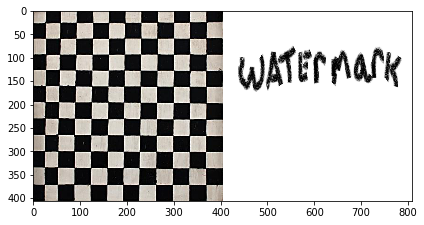

In [242]:
#@title Select an Image {display-mode: "form", run: "auto"}
#@markdown ---
select_image = 'chequered_0121.jpg' #@param ['knitted_0175.jpg', 'striped_0088.jpg', 'banded_0009.jpg', 'fibrous_0035.jpg', 'chequered_0121.jpg']
select_watermark = 'watermark_brushCrayon.png' #@param ['watermark_brushCrayon.png', 'watermark_text.png', 'watermark_paintBrush.png']
#@markdown ---

# loads a photo from the file path and file name
## creating an Image_Processing Object
img = Photo.load(fp=img_path, fname=select_image)
img = Image_Processing(fp=img_path, fname=select_image, img=img)

# loads a photo from the file path and file name
## creating an Image_Processing Object
watermark = Photo.load(fp=water_path, fname=select_watermark)
watermark = Image_Processing(fp=water_path, fname=select_watermark, img=watermark)

print("Set the following...\nImage: {}\nWatermark: {}".format(select_image, select_watermark ))

# match the size for displaying
temp_water = transform.resize(watermark.image, img.shape, cval=0) 
ximg = [img.image, temp_water]
ximg = np.concatenate(ximg, axis=1)

Photo.show_array(ximg)


Set the following...
 Blur_deviation: 4
 Kernel Size: (7, 7)


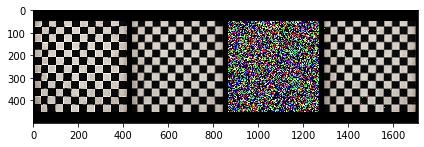

In [260]:
#@title Select Parameters { display-mode: "form", run: "auto" }
#@markdown ---
#@markdown Set Processing parameters
Image_Blur_Deviation = 4  #@param {type: "slider", min: 0, max: 4, step: 1}
kernel_size = 7 #@param {type:"slider", min:1, max:11, step:2}
mean_noise = 0 #@param {type: "number"}
sigma_noise = 2.2 #@param {type:"slider", min:0, max:4, step:0.1}
#@markdown Boarder Color
red = 0 #@param {type:"slider", min:0, max:255, step:1}
green = 0 #@param {type:"slider", min:0, max:255, step:1}
blue = 0 #@param {type:"slider", min:0, max:255, step:1}
#@markdown Boarder Thickness
boarder_thickness = 47 #@param {type:"slider", min:0, max:100, step:1}
#@markdown ---

print("Set the following...\n Blur_deviation: {}\n Kernel Size: {}".format(Image_Blur_Deviation, (kernel_size, kernel_size) ))

img.blur_img((kernel_size, kernel_size), Image_Blur_Deviation)

# Setting noise levels
img.noise_img(mean_noise, sigma_noise) # noise image is set. 

# Setting Blurred image + Noise
img_model = img.blur.image + img.noise.image

# Adding watermark...

# Set Shape of desired watermark
adjust_shape = lambda h, w, c, size_param: np.array([int(size_param*h), int(size_param*w), c])
h, w, c = img.shape
target_shape = adjust_shape(h, w, c, size_param)
# Set the location of the watermark
location = [int(s1*(h-target_shape[0])), int(s2*(w-target_shape[1]))]
composite_img = img.alpha_blend_watermark(watermark.image, target_shape, location, alpha)



value = [red, green, blue]  # RGB color value

'''
top: It is the border width in number of pixels in top direction. 
bottom: It is the border width in number of pixels in bottom direction. 
left: It is the border width in number of pixels in left direction. 
right: It is the border width in number of pixels in right direction. 
'''
boarder = lambda value, bt, imgs: [ cv2.copyMakeBorder(i, bt, bt, int(bt/4), int(bt/4), cv2.BORDER_CONSTANT, value=value) for i in imgs ]
x = [img.image, img.blur.image, img.noise.image, img_model]
x = boarder(value, boarder_thickness, x)
image_band = np.concatenate(x, axis=1)
Photo.show_array(image_band)



Add watermark and a form field to explore all combonations 

In [ ]:
#@title Watermark Parameters { display-mode: "form", run: "auto" }
#@markdown alpha level to blend in watermark
alpha = 0.34 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown size level to transform watermark
size_param = 1 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown sy is percent location accros y-axis 

#@markdown sx is percent location accros x-axis
sy = 0 #@param {type:"slider", min:0, max:1, step:0.01}
sx = 0 #@param {type:"slider", min:0, max:1, step:0.01}






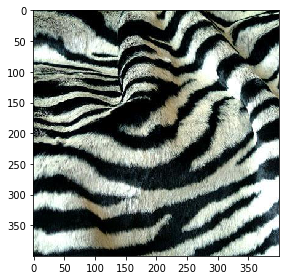

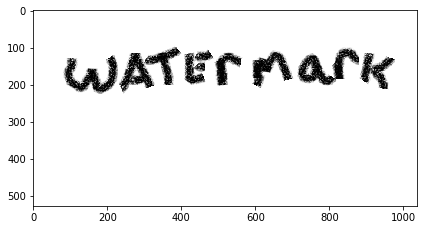

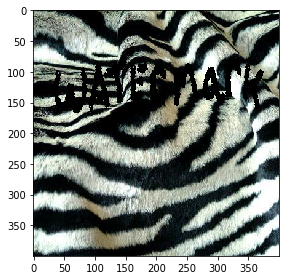

In [ ]:
# Set file paths
## Image file Path
img_path = os.path.join(workspace_path, "Full_Images/Custom")
image_names = listdir(img_path)

# loading photos into a Dictionary
book = dict()  
for fname in image_names:
  all_img = Photo.load(fp=img_path, fname=fname)
  img = Image_Processing(img_path, fname, all_img)
  img.add_to_book(book)

test_img = book[list(book.keys())[1] ]

## Watermark file path
water_book = dict() 
water_path = os.path.join(workspace_path, "Watermarks/")

# loading watermarks into a Dictionary
watermark_names = listdir(water_path)
for water_fname in watermark_names:
  all_img = Photo.load(fp=water_path, fname=water_fname)
  img = Image_Processing(water_path, water_fname, all_img)
  img.add_to_book(water_book)

# Photo.show_multiple(water_book)
water_img = water_book[list(water_book.keys())[0]] 

# Set Shape of desired watermark
adjust_shape = lambda h, w, c, size_param: np.array([int(size_param*h), int(size_param*w), c])
h, w, c = test_img.shape
size_param = 1
target_shape = adjust_shape(h, w, c, size_param)
# Set the location of the watermark
s1, s2 = 0, 0
location = [int(s1*(h-target_shape[0])), int(s2*(w-target_shape[1]))]
alpha = 1
composite_img = test_img.alpha_blend_watermark(water_img.image, target_shape, location, alpha)



result_img = Image_Processing(workspace_path, "resulting_watermark.png", composite_img )

# Show images
test_img.show()
water_img.show()
result_img.show()